### Simple Decision Trees (D)

#### Instructions
* What accuracy can you achieve with a depth of 3?
* Plot the corresponding tree with graphviz
* Do you get better results if you reduce the number of dimensions with PCA first?

### Task D

#### Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
with np.load('swissroads_highlevel_features.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    features_tr = npz_file['features_train']
    labels_tr = npz_file['labels_train']
    features_va = npz_file['features_valid']
    labels_va = npz_file['labels_valid']
    features_te = npz_file['features_test']
    labels_te = npz_file['labels_test']
    imgs_tr = npz_file['imgs_train']
    imgs_va = npz_file['imgs_valid']
    imgs_te = npz_file['imgs_test']

print('features_tr:', features_tr.shape)
print('labels_tr:', labels_tr.shape)
print('features_va:', features_va.shape)
print('labels_va:', labels_va.shape)
print('features_te:', features_te.shape)
print('labels_te:', labels_te.shape)
print('imgs_tr:', imgs_tr.shape)
print('imgs_va:', imgs_va.shape)
print('imgs_te:', imgs_te.shape)

features_tr: (280, 2048)
labels_tr: (280,)
features_va: (139, 2048)
labels_va: (139,)
features_te: (50, 2048)
labels_te: (50,)
imgs_tr: (280, 299, 299, 3)
imgs_va: (139, 299, 299, 3)
imgs_te: (50, 299, 299, 3)


In [3]:
X_tr = features_tr
X_va = features_va
X_te = features_te
y_tr = labels_tr
y_va = labels_va
y_te = labels_te
labels = ['bike','car','motorcycle','other','truck','van']

#### i) Accuracy with depth of 3?

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

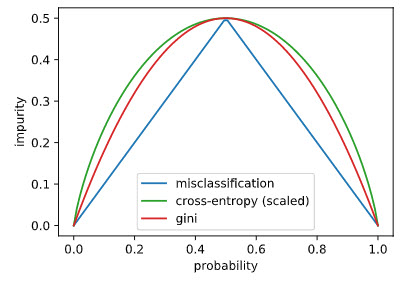

In [5]:
from IPython.display import Image
Image(filename='DecisionTree2.jpg')

In [6]:
dt.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [7]:
print('Accuracy on train set: {:.3f}'.format(dt.score(X_tr, y_tr)))
print('Accuracy on validation set: {:.3f}'.format(dt.score(X_va, y_va)))

Accuracy on train set: 0.771
Accuracy on validation set: 0.719


#### ii) Visualize Decision Tree of depth 3

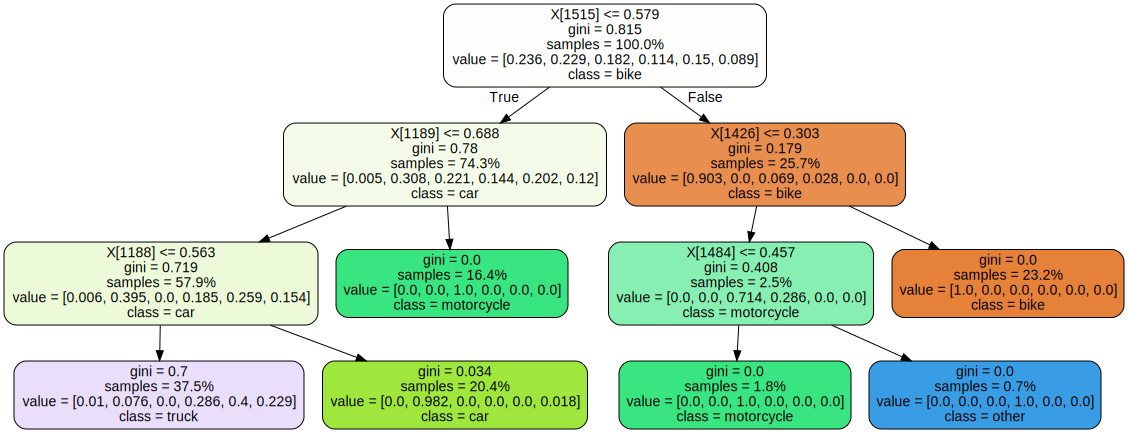

In [8]:
from sklearn.tree import export_graphviz
import graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    #feature_names=encoded_df.drop(columns=['name','survived']).columns, 
    class_names=labels,
    filled=True, rounded=True, proportion=True)

# Display decision tree
graphviz.Source(dot_data)

#### iii) Do we get better results when reducing dimensionality with PCA?
* Build initial Decision tree of max depth 3 with dimensionality reduction to 5 components and standardization as "proof of concept" => accuracy is already higher than Decision tree without dimensionality reduction: 80% on validation set
* Build Grid search using for loops to tune hyperparameters (objective of avoiding over-fitting and over-complexity) => reach accuracy on validation of 82%

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X_tr_rescaled = scaler.fit_transform(X_tr)
X_va_rescaled = scaler.transform(X_va)
X_te_rescaled = scaler.transform(X_te)

pca = PCA(n_components=5)

pca.fit(X_tr_rescaled)

pve = pca.explained_variance_ratio_

print('Proportion of variance exaplined: {:.3f}'.format(pve.sum()))

Proportion of variance exaplined: 0.336


In [10]:
X_tr_rescaled_5d = pca.transform(X_tr_rescaled)
X_va_rescaled_5d = pca.transform(X_va_rescaled)
X_te_rescaled_5d = pca.transform(X_te_rescaled)

In [11]:
X_tr_rescaled_5d.shape

(280, 5)

In [12]:
# from sklearn.tree import DecisionTreeClassifier
# Create decision tree
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dt2.fit(X_tr_rescaled_5d,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [13]:
print('Accuracy 5 components, depth 3 train: {:.3f}'.format(dt2.score(X_tr_rescaled_5d,y_tr)))
print('Accuracy 5 components, depth 3 validation: {:.3f}'.format(dt2.score(X_va_rescaled_5d,y_va)))

Accuracy 5 components, depth 3 train: 0.843
Accuracy 5 components, depth 3 validation: 0.806


In [14]:
results = []
for comp in np.arange(1,21):
    for m_depth in np.arange(1,21):
        pca_grid = PCA(n_components=comp)
        pca_grid.fit(X_tr_rescaled,y=None)
        pve_grid = pca_grid.explained_variance_ratio_.sum()
        
        X_tr_rescaled_grid = pca_grid.transform(X_tr_rescaled)
        X_va_rescaled_grid = pca_grid.transform(X_va_rescaled)
        X_te_rescaled_grid = pca_grid.transform(X_te_rescaled)
        
        dt_grid = DecisionTreeClassifier(criterion='gini', max_depth=m_depth, random_state=0)
        dt_grid.fit(X_tr_rescaled_grid, y_tr)
        
        score_train = dt_grid.score(X_tr_rescaled_grid, y_tr)
        score_valid = dt_grid.score(X_va_rescaled_grid, y_va)
        
        results.append({
            'n_components':comp,
            'max_depth':m_depth,
            'varience_expl':pve_grid,
            'accuracy_train':score_train,
            'accuracy_valid':score_valid,
        })

In [15]:
dt_grid_results = pd.DataFrame(results)
dt_grid_results[dt_grid_results['accuracy_train'] < 0.9].sort_values(by='accuracy_valid',ascending=False).head(20)

,accuracy_train,accuracy_valid,max_depth,n_components,varience_expl
43,0.896429,0.827338,4,3,0.258598
122,0.853571,0.820144,3,7,0.382133
282,0.857143,0.820144,3,15,0.495551
182,0.857143,0.820144,3,10,0.433247
222,0.857143,0.820144,3,12,0.459736
262,0.857143,0.820144,3,14,0.484495
322,0.857143,0.820144,3,17,0.516014
242,0.857143,0.812950,3,13,0.472218
382,0.857143,0.812950,3,20,0.543215
362,0.857143,0.812950,3,19,0.534628


**Based on above grid search following parametres seem to (1) avoid over-fitting while (2) avoid over-complxity (3) attain good accuary:**
* Decision Tree max depth = 3
* PCA components = 10

In [16]:
pca_final = PCA(n_components=10)
pca_final.fit(X_tr_rescaled)
X_tr_rescaled_final = pca_final.transform(X_tr_rescaled)
X_va_rescaled_final = pca_final.transform(X_va_rescaled)
X_te_rescaled_final = pca_final.transform(X_te_rescaled)
dt_pca_final = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dt_pca_final.fit(X_tr_rescaled_final, y_tr)
        
dt_pca_score_train = dt_pca_final.score(X_tr_rescaled_final, y_tr)
dt_pca_score_valid = dt_pca_final.score(X_va_rescaled_final, y_va)
dt_pca_score_test = dt_pca_final.score(X_te_rescaled_final, y_te)

print('Accuracy on train set: {:.3f}'.format(dt_pca_score_train))
print('Accuracy on validation set: {:.3f}'.format(dt_pca_score_valid))
print('Decision Tree accuracy: {:.3f}'.format(dt_pca_score_test))

Accuracy on train set: 0.857
Accuracy on validation set: 0.820
Decision Tree accuracy: 0.820


In [17]:
%store dt_pca_score_test

Stored 'dt_pca_score_test' (float64)


#### Notes/Quesions on Task D (Greg):
* Shall I have use Standardize data before creating DecisionTree object? Or not needed as already re-scaled when high-level features exported? *(cell 6)*
* Is it correct to use StandardScaler on validation and test sets as well? *(cell 9)*
* Shall I use validation and test sets as well to fit PCA for transformation? *(cell 9)*